Testing biological calibration of the Salish Sea Atlantis Model

In [1]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/')
scenario_paths = sorted([p for p in scenario_root.glob('v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL*/outputSalishSea.nc')])
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)
    print(path.parent.stem)

v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL
v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing
v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL2


In [3]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [4]:
strait_of_georgia = [79,80,81,82,83,84,85,86,88,90,91,92,94,96,98,101,102]
sog_south = [54,64,68,79]
sog_center = [62,80,81,82,83,84,85]
sog_north = [86,88,90,91,92,94,96,98,101,102]
puget_sound_main = [19,20,21,23,26,28,31,32]
fraser_river_plume = [75,80,81]

In [5]:
# Reading in Atlantis map

shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
sog_s_df = data_df.loc[sog_south]
sog_c_df = data_df.loc[sog_center]
sog_n_df = data_df.loc[sog_north]
ps_df = data_df.loc[data_df.Region=='Puget Sound']
fr_df = data_df.loc[fraser_river_plume]

In [6]:
crashbox = [74]
crash_df = data_df.loc[crashbox]

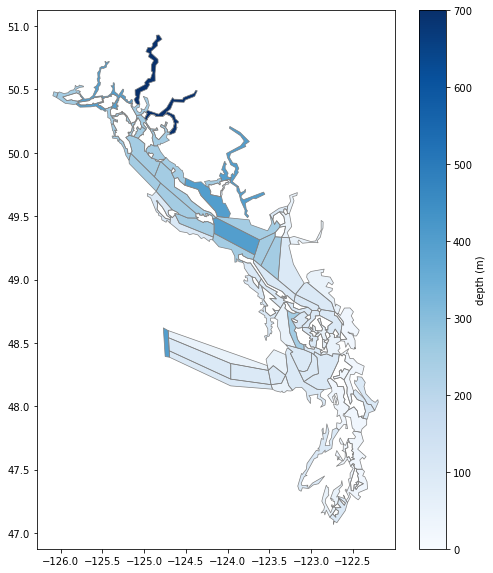

In [7]:
# Location Map
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'BOTZ', ax=ax, cax=cax,cmap=cm.Blues,
    legend=True, legend_kwds={'label': 'depth (m)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#crash_df.boundary.plot(ax=ax, color='red',linewidths=0.5)
#ps_df.boundary.plot(ax=ax, color='red');
#fr_df.boundary.plot(ax=ax, color='orange');
land_df.plot(ax=ax, color='white');

# Diatoms Biomass Comparisons

### Atlantis Model for Puget Sound (AMPS) Data

In [8]:
# Extracting AMPS diatom data
amps_filename = "AMPS_OUT_7.nc"
amps_data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/" + amps_filename
amps_data = xr.open_dataset(str(amps_data_file), decode_cf=True) #[t, box, z]

amps_time = amps_data.t
amps_volume = amps_data.volume
diatoms_amps_tbz = amps_data.Lrg_Phyto_N * amps_volume #convert to mg N 
diatoms_amps_tb = diatoms_amps_tbz[:,:,0:6].sum(axis=2)
diatoms_amps_t = diatoms_amps_tb.sum(axis=1) * 1e-9 # convert from mg N to tonnes

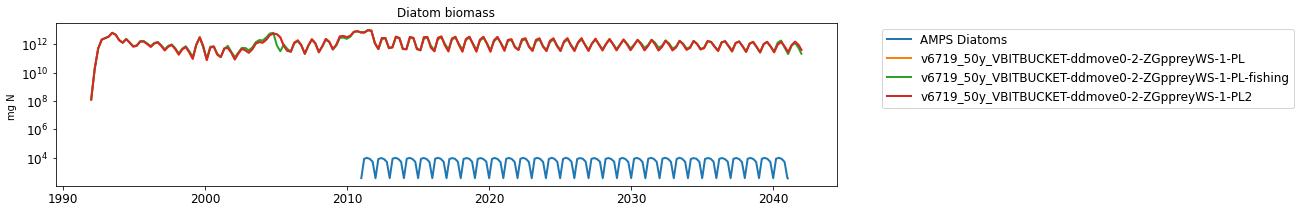

In [9]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(amps_time, diatoms_amps_t, linewidth = 2) #semilogy
ax.set_title('Diatom biomass', fontsize = 12)
ax.set_ylabel('mg N ')
ax.tick_params(labelsize=12)
labels = ['AMPS Diatoms']
for scenario, label in zip(scenario_datasets,scenario_labels):
    var_tbl = scenario.Diatom_N[:,puget_sound_main,0:6] * scenario.volume[:,puget_sound_main,0:6]
    var_tb = var_tbl.sum(axis=2)
    ax.semilogy(scenario.t, var_tb.mean(axis=1), linewidth = 2) 
    labels.append(label)
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

### SalishSeaCast Data

In [10]:
# SalishSeaCast daily averaged diatom data for 30 days in 2007
ssc_data = xr.open_dataset('/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_compressed_20070101_20070131.nc')
mesh = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')

ssc_volume = (mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})
diatoms_SSC_tzyx = ssc_data.diatoms # [t,z,y,x]
diatoms_SSC_tzyx = diatoms_SSC_tzyx * ssc_volume # convert from mmol m-3 to mmol
# Convert mmol N * 14.0067 mg/mmol 
diatoms_SSC_tzy = diatoms_SSC_tzyx.sum(axis=3)
diatoms_SSC_tz = diatoms_SSC_tzy.sum(axis=2)
diatoms_SSC_t = diatoms_SSC_tz.sum(axis=1) * (14.0067) #convert to mg N

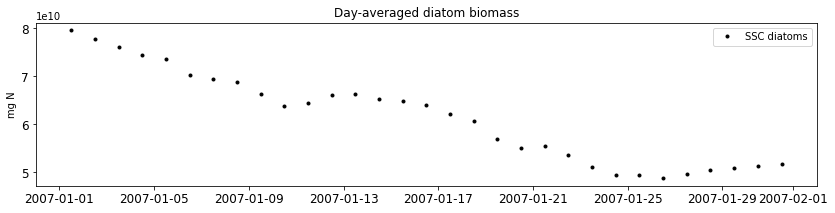

In [11]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.plot(ssc_data.time, diatoms_SSC_t, 'k.', linewidth = 2) #semilogy
#ax.plot(ssam_time[5:37], diatoms_SSAM_t[5:37],'b.', linewidth = 2)
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('mg N')
ax.tick_params(labelsize=12)
ax.legend(['SSC diatoms'], loc='best'); #'SSAM diatoms'

### SSAM Data

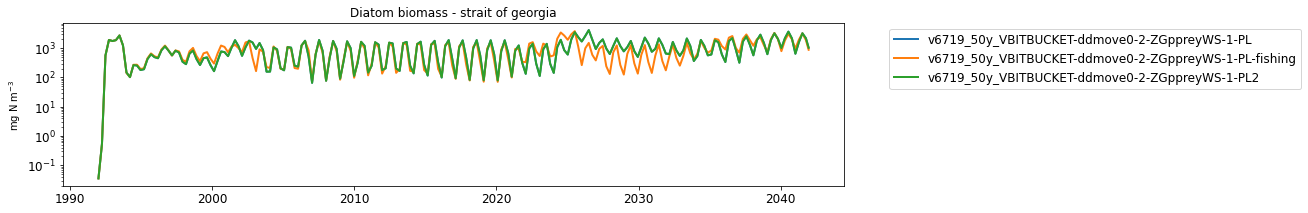

In [12]:
fig, ax = plt.subplots(figsize = (14,3)) 
labels = []

for scenario, label in zip(scenario_datasets,scenario_labels):
    #var_tbl = scenario.Diatom_N[:,strait_of_georgia,0:6] * scenario.volume[:,strait_of_georgia,0:6]
    #var_tb = var_tbl.sum(axis=2)
    ax.semilogy(scenario.t, scenario.Diatom_N[:,strait_of_georgia,5].mean(axis=1), linewidth = 2) #semilogy
    labels.append(label)
    ax.set_title('Diatom biomass - strait of georgia', fontsize = 12)
    ax.set_ylabel('mg N m$^{-3}$')
    ax.tick_params(labelsize=12)
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);


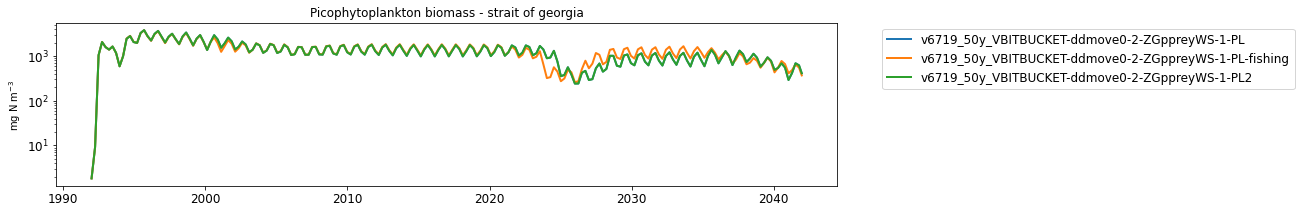

In [13]:
fig, ax = plt.subplots(figsize = (14,3))
labels = []
for scenario, label in zip(scenario_datasets,scenario_labels):
    ax.semilogy(scenario.t, scenario.PicoPhytopl_N[:,strait_of_georgia,5].mean(axis=1), linewidth = 2) #semilogy
    labels.append(label)
    ax.set_title('Picophytoplankton biomass - strait of georgia', fontsize = 12)
    ax.set_ylabel('mg N m$^{-3}$')
    ax.tick_params(labelsize=12)
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

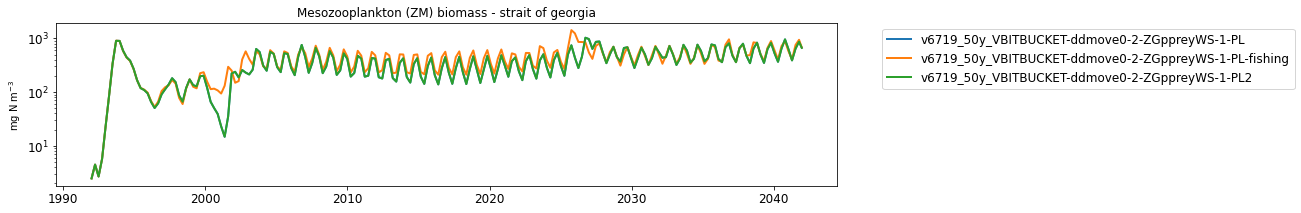

In [14]:
fig, ax = plt.subplots(figsize = (14,3))
labels = []
for scenario, label in zip(scenario_datasets,scenario_labels):
    ax.semilogy(scenario.t, scenario.Zoo_N[:,strait_of_georgia,5].mean(axis=1), linewidth = 2) #semilogy
    labels.append(label)
    ax.set_title('Mesozooplankton (ZM) biomass - strait of georgia', fontsize = 12)
    ax.set_ylabel('mg N m$^{-3}$')
    ax.tick_params(labelsize=12)
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

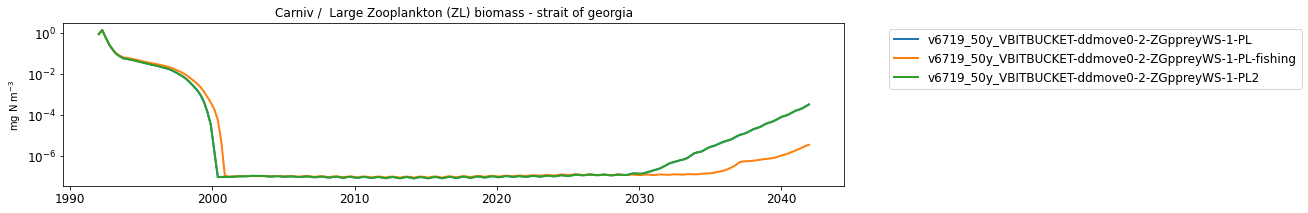

In [15]:
fig, ax = plt.subplots(figsize = (14,3))
labels = []
for scenario, label in zip(scenario_datasets,scenario_labels):
    ax.semilogy(scenario.t, scenario.Carniv_Zoo_N[:,strait_of_georgia,5].mean(axis=1), linewidth = 2) #semilogy
    labels.append(label)
    ax.set_title('Carniv /  Large Zooplankton (ZL) biomass - strait of georgia', fontsize = 12)
    ax.set_ylabel('mg N m$^{-3}$')
    ax.tick_params(labelsize=12)
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

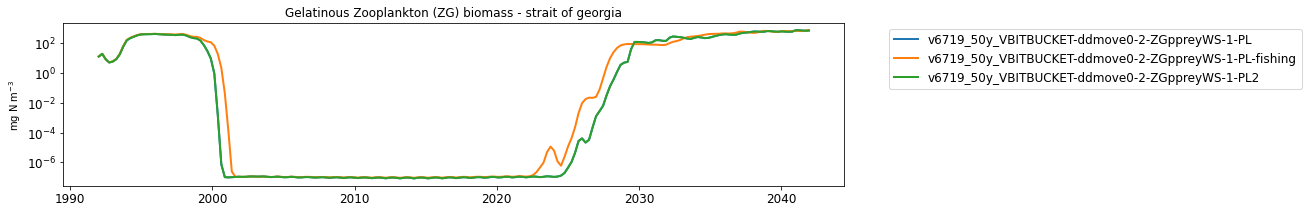

In [16]:
fig, ax = plt.subplots(figsize = (14,3))
labels = []
for scenario, label in zip(scenario_datasets,scenario_labels):
    ax.semilogy(scenario.t, scenario.Gelat_Zoo_N[:,strait_of_georgia,5].mean(axis=1), linewidth = 2) #semilogy
    labels.append(label)
    ax.set_title('Gelatinous Zooplankton (ZG) biomass - strait of georgia', fontsize = 12)
    ax.set_ylabel('mg N m$^{-3}$')
    ax.tick_params(labelsize=12)
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

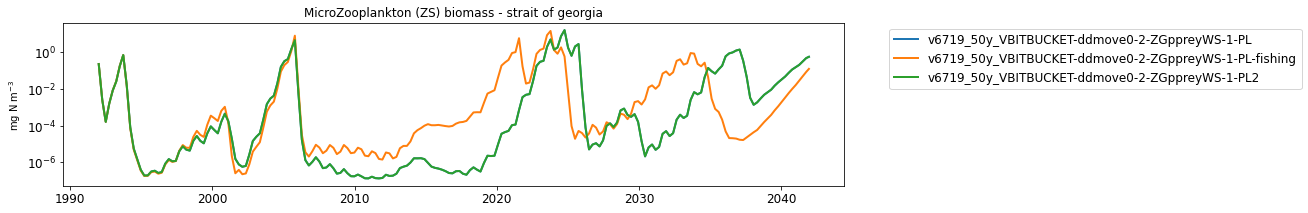

In [17]:
fig, ax = plt.subplots(figsize = (14,3))
labels = []
for scenario, label in zip(scenario_datasets,scenario_labels):
    ax.semilogy(scenario.t, scenario.MicroZoo_N[:,strait_of_georgia,5].mean(axis=1), linewidth = 2) #semilogy
    labels.append(label)
    ax.set_title('MicroZooplankton (ZS) biomass - strait of georgia', fontsize = 12)
    ax.set_ylabel('mg N m$^{-3}$')
    ax.tick_params(labelsize=12)
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

# Diatom & Plankton Distribution

In [18]:
def plot_pelagic_depth(group, location, scenario_datasets, scenario_labels):

    fig = plt.figure(figsize=(18, 27), facecolor='white')
    gs = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1]) 

    depth = [450, 250, 100, 50, 25, 0] #700, 450, 

    for species in group:
        bio_index = (list(group).index(species))

        if bio_index < 4:
            position = 0, bio_index
        elif bio_index > 8: 
            position = 2, bio_index-8
        else :
            position = 1, bio_index-4

        ax = fig.add_subplot(gs[position])

        for data, label in zip(scenario_datasets, scenario_labels):
            pelagic_oiled = data.variables[group[species] + '_N'][len(data.t)-5:len(data.t),location,0:6]
            #pelagic_oiled = pelagic_oiled_m3 * data.volume[len(data.t)-5:len(data.t),location,0:6]
            p_oiled = pelagic_oiled.mean(axis=1)
            p_oiled = p_oiled.mean(axis=0)
            ax.plot(p_oiled, depth,linewidth = 2) #color=line_colour, linestyle=line_type,
            #ax.pcolormesh(p_oiled[:,0], pelagic_oiled[0,:], cmap='RdBu') #,vmin=z_min, vmax=z_max
        ax.set_ylim(100, 0)  # decreasing depth
        ax.set_title(species)
        ax.set_ylabel('depth, m')
        ax.set_xlabel('mg N m$^{-3}$')
    ax.legend(scenario_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);


In [ ]:
plot_pelagic_depth(groups.phytoplankton, groups.strait_of_georgia, scenario_datasets, scenario_labels) # water column only

## Pelagic

In [20]:
def map_surface(variable_name, v_max=None, v_min=None):
  
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, height_ratios=[3, 3, 3])
    
    for scenario, label in zip(scenario_datasets, scenario_labels):

        b_index = (list(scenario_labels).index(label))

        if b_index < 3:
            position = 0, b_index
        elif b_index > 5: 
            position = 2, b_index-6
        else :
            position = 1, b_index-3
        dVar_s = scenario.variables[variable_name][len(scenario.t)-5:len(scenario.t),:,5]
        #scen = scenario.variables[variable_name][len(scenario.t)-1,:,5]
        scen = dVar_s.mean(axis=0)
        nm = str(label).split(sep = '_')

        # Add scenario data to Atlantis spatial data
        data_df['scen'] = scen
        data_df.loc[land_boxes, 'scen'] = 0

        ax = fig.add_subplot(gs[position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = data_df.plot(column = 'scen', ax=ax, cax=cax, vmin=v_min, vmax=v_max, #norm=colors.LogNorm(vmin=1, vmax=data_df.scen.max()),
            legend=True, legend_kwds={'label': variable_name},
            )
        ax.set_title(nm[-1], fontsize = 12)
        data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        #crash_df.boundary.plot(ax=ax, color='red', linewidths=0.7);

In [21]:
def map_water_column(variable_name):
  
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, height_ratios=[3, 3, 3])
    
    for scenario, label in zip(scenario_datasets, scenario_labels):

        b_index = (list(scenario_labels).index(label))

        if b_index < 3:
            position = 0, b_index
        elif b_index > 5: 
            position = 2, b_index-6
        else :
            position = 1, b_index-3

        dVar_s = scenario.variables[variable_name][len(scenario.t)-5:len(scenario.t),:,0:6]
        scen_bl = dVar_s.mean(axis=0)
        scen = scen_bl.sum(axis=1)
        scen[0] = 0
        nm = str(label).split(sep = '_')

        # Add scenario data to Atlantis spatial data
        data_df['scen'] = scen
        data_df.loc[land_boxes, 'scen'] = 0

        ax = fig.add_subplot(gs[position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = data_df.plot(column = 'scen', ax=ax, cax=cax, norm=colors.LogNorm(vmin=1, vmax=data_df.scen.max()), #vmin=0, vmax=20, cmap=cm.Greens, vmin=v_min, vmax=v_max
            legend=True, legend_kwds={'label': variable_name},
            )
        ax.set_title(nm[-1], fontsize = 12)
        data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');

In [22]:
def map_water_column_linear(variable_name, v_min=None, v_max=None):
  
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, height_ratios=[3, 3, 3])
    
    for scenario, label in zip(scenario_datasets, scenario_labels):

        b_index = (list(scenario_labels).index(label))

        if b_index < 3:
            position = 0, b_index
        elif b_index > 5: 
            position = 2, b_index-6
        else :
            position = 1, b_index-3

        dVar_s = scenario.variables[variable_name][len(scenario.t)-5:len(scenario.t),:,0:6]
        scen_bl = dVar_s.mean(axis=0)
        scen = scen_bl.sum(axis=1)
        scen[0] = 0
        nm = str(label).split(sep = '_')

        # Add scenario data to Atlantis spatial data
        data_df['scen'] = scen
        data_df.loc[land_boxes, 'scen'] = 0

        ax = fig.add_subplot(gs[position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = data_df.plot(column = 'scen', ax=ax, cax=cax, vmin=v_min, vmax=v_max,
            legend=True, legend_kwds={'label': variable_name},
            )
        ax.set_title(nm[-1], fontsize = 12)
        data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');

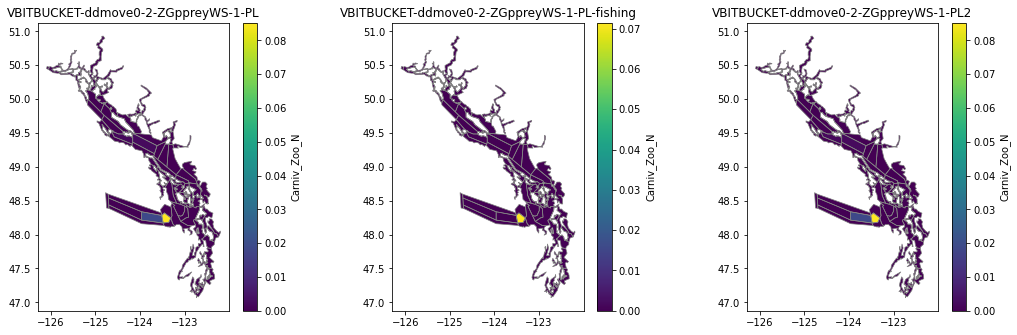

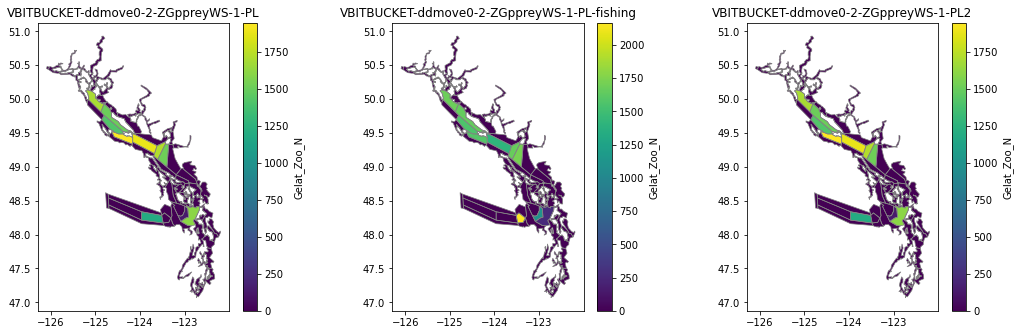

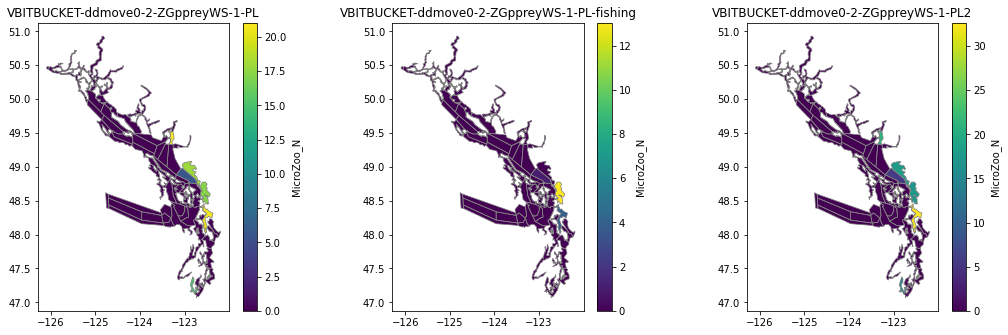

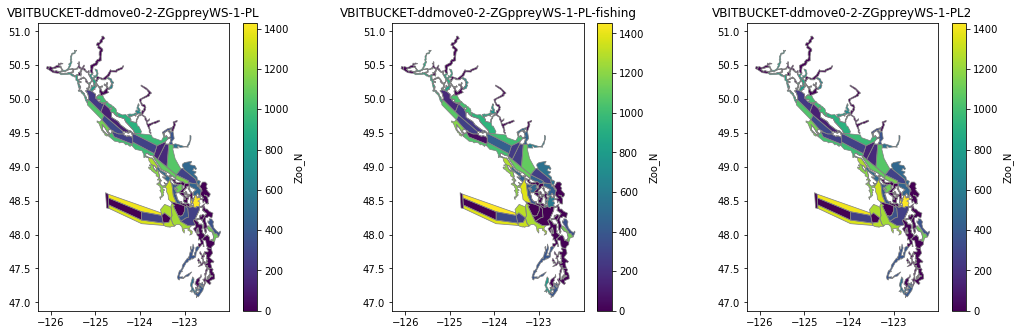

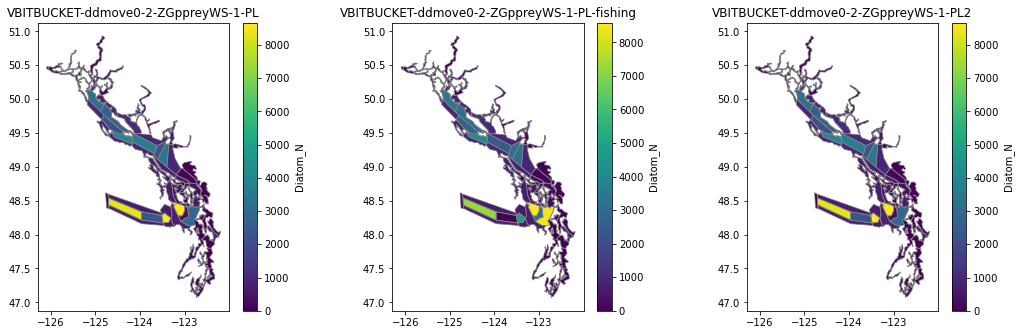

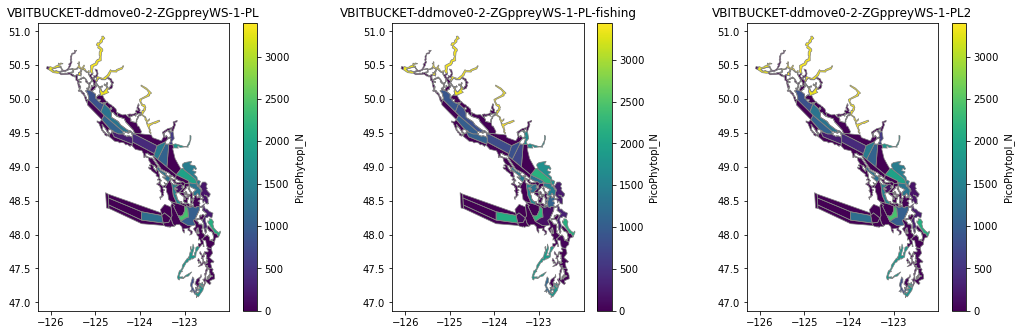

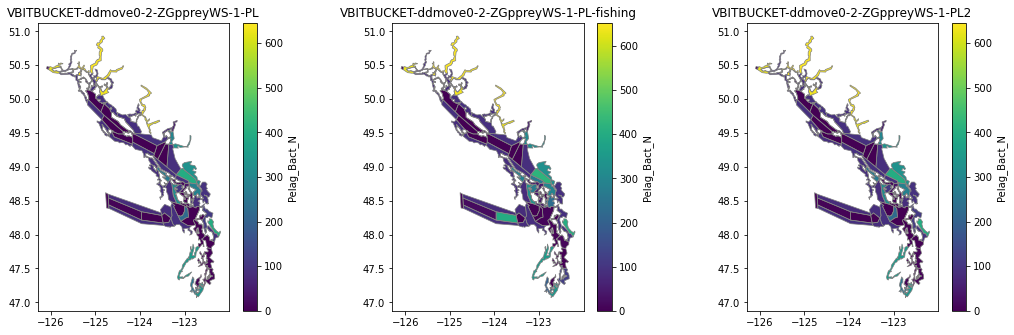

In [23]:
group = groups.plankton
for species in group:
    spp_name = str(group[species]) + '_N'
    map_surface(spp_name)

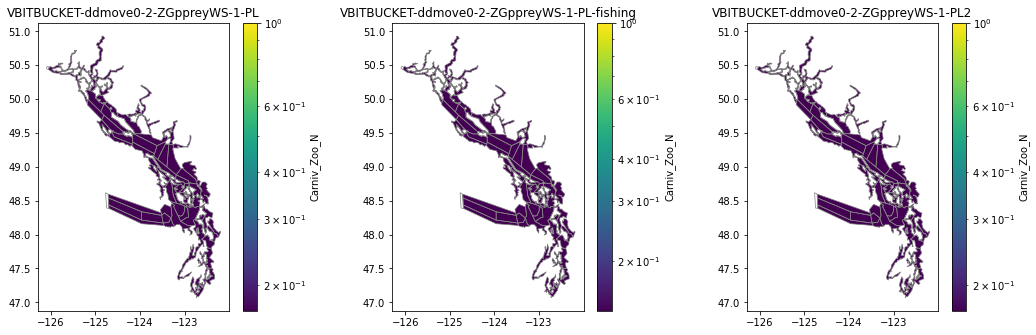

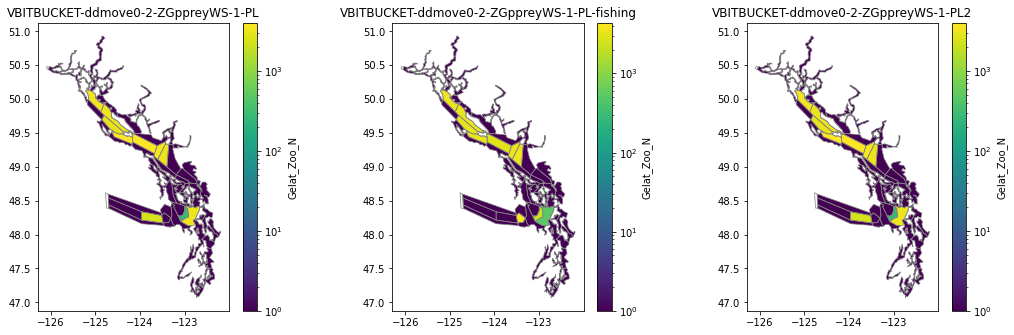

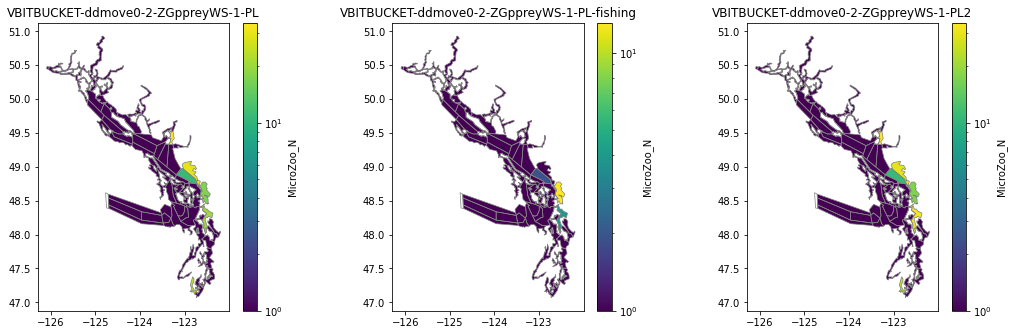

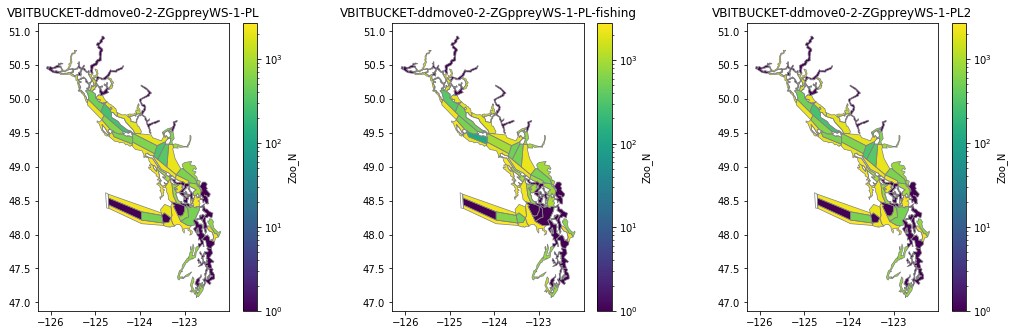

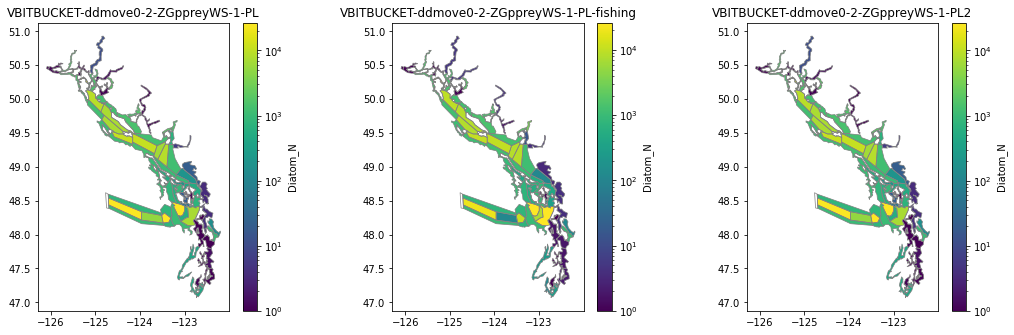

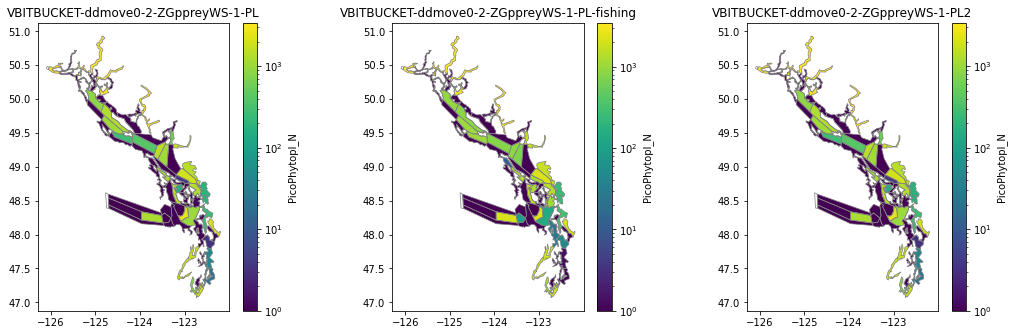

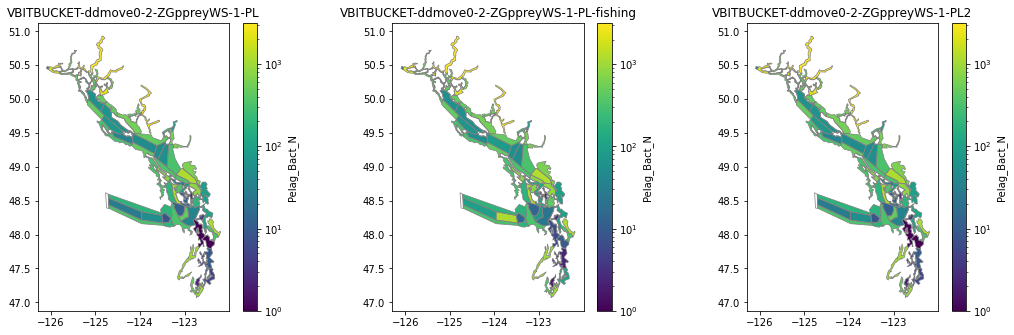

In [24]:
group = groups.plankton
for species in group:
    spp_name = str(group[species]) + '_N'
    map_water_column(spp_name)

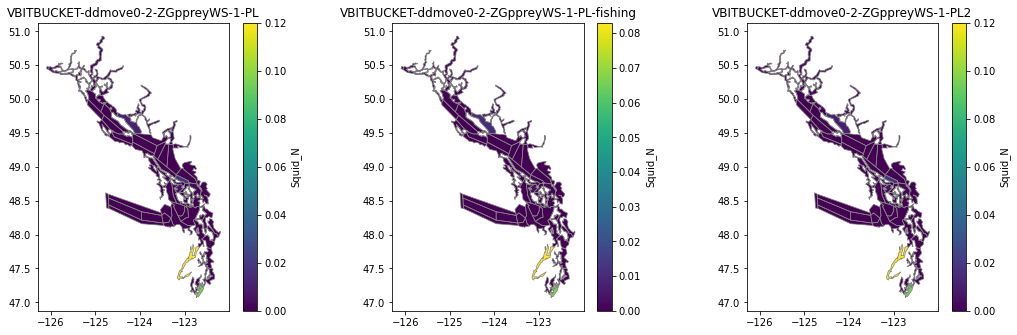

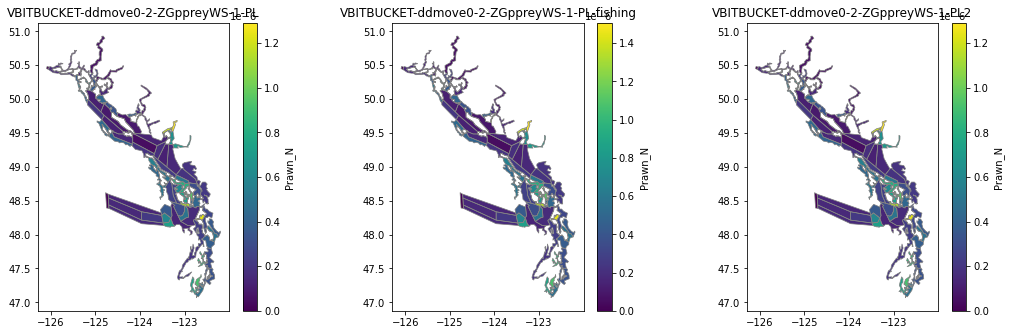

In [25]:
group = groups.pelagic_invertebrates
for species in group:
    spp_name = str(group[species]) + '_N'
    map_water_column_linear(spp_name)

# Benthic

In [26]:
def map_benthic(variable_name, v_max=None, v_min=None):
  
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, height_ratios=[3, 3, 3])
    
    for scenario, label in zip(scenario_datasets, scenario_labels):

        b_index = (list(scenario_labels).index(label))

        if b_index < 3:
            position = 0, b_index
        elif b_index > 5: 
            position = 2, b_index-6
        else :
            position = 1, b_index-3

        dVar_s = scenario.variables[variable_name][len(scenario.t)-(5):len(scenario.t),:]
        scen = dVar_s.mean(axis=0)
        nm = str(label).split(sep = '_')

        # Add scenario data to Atlantis spatial data
        data_df['scen'] = scen
        data_df.loc[land_boxes, 'scen'] = 0
        ax = fig.add_subplot(gs[position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = data_df.plot(column = 'scen', ax=ax, cax=cax, #norm=colors.LogNorm(vmin=1, vmax=data_df.scen.max()), #vmin=v_min, vmax=v_max vmin=0, vmax=20, cmap=cm.Greens,
            legend=True, legend_kwds={'label': variable_name},
            )
        ax.set_title(nm[-1], fontsize = 12)
        data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        #crash_df.boundary.plot(ax=ax, color='red', linewidths=0.7);

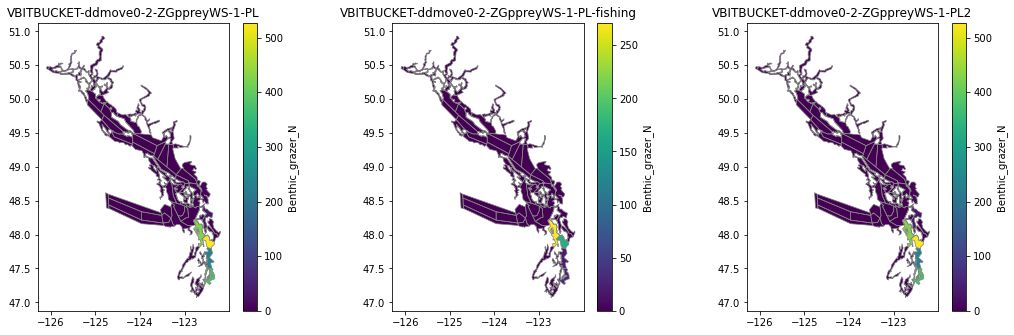

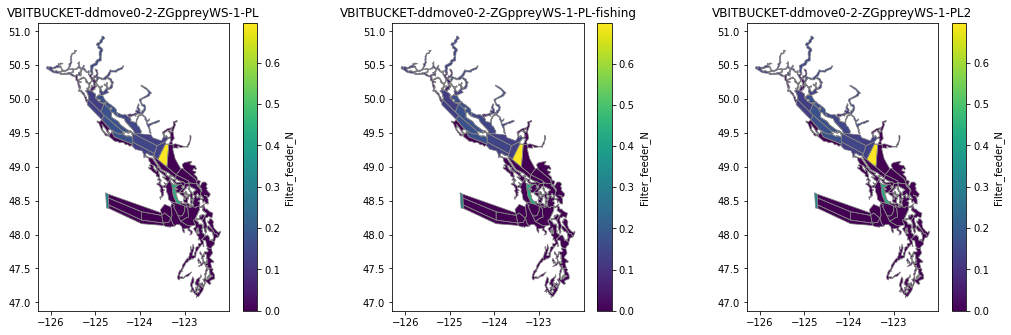

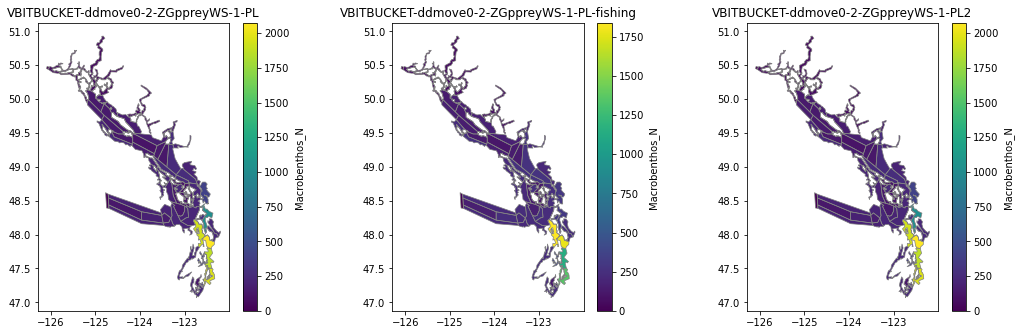

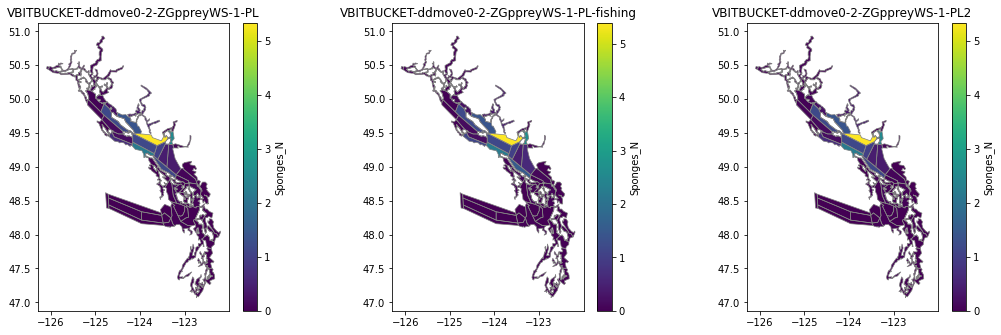

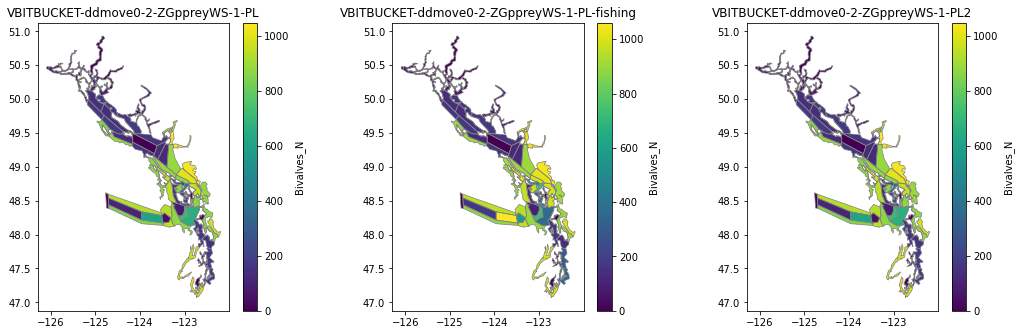

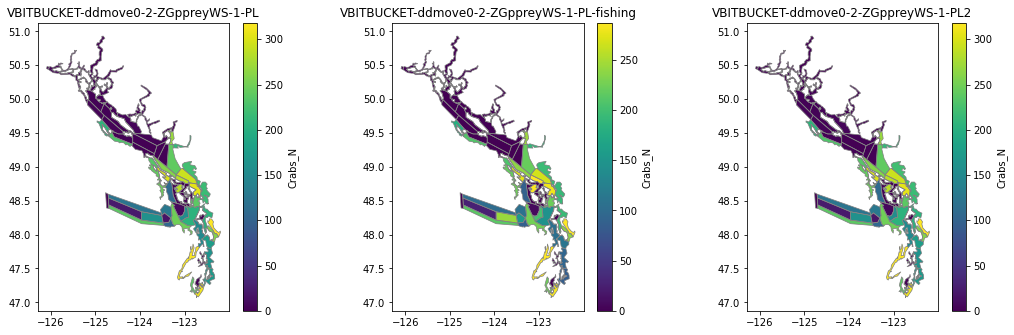

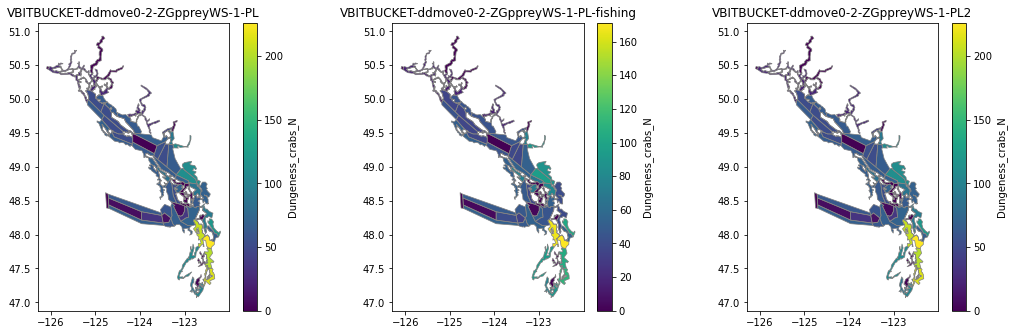

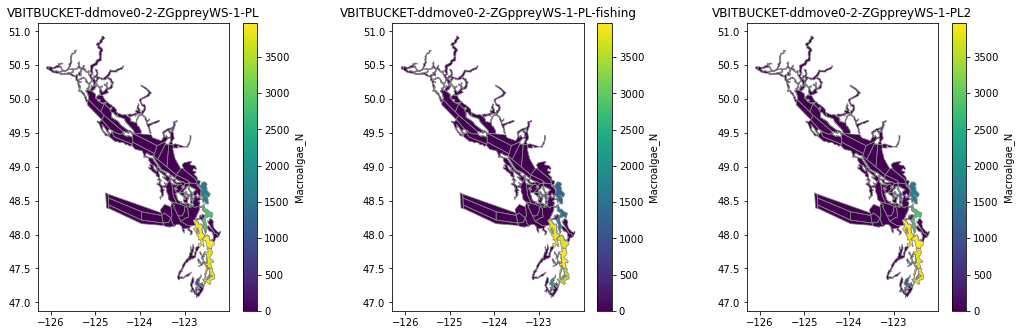

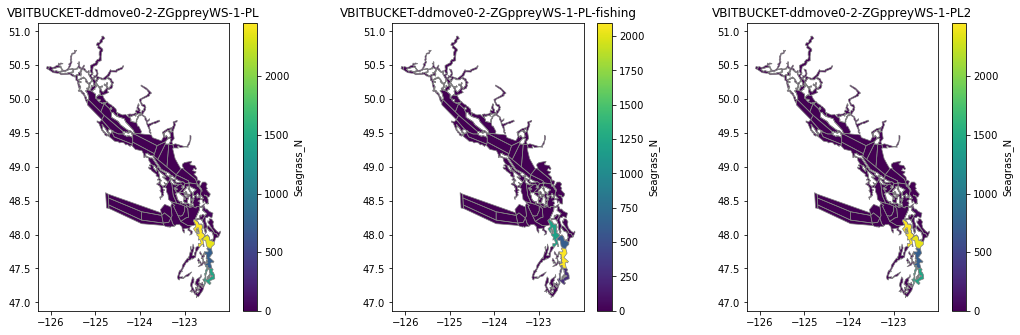

In [27]:
group = groups.benthos
for species in group:
    spp_name = str(group[species]) + '_N'
    map_benthic(spp_name)

# Vertebrates

## Wild salmon

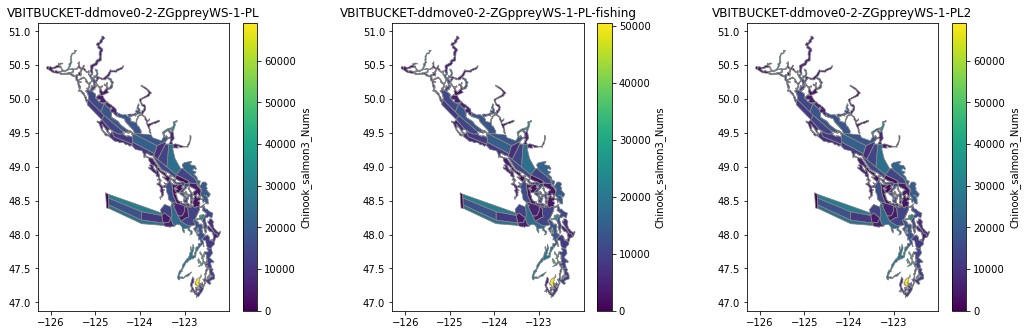

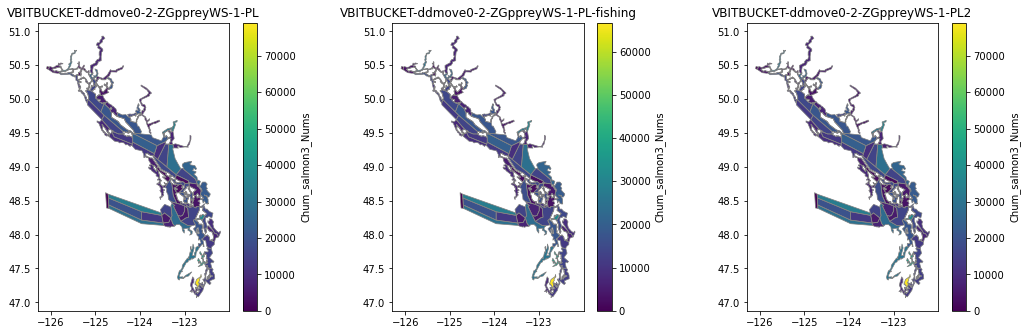

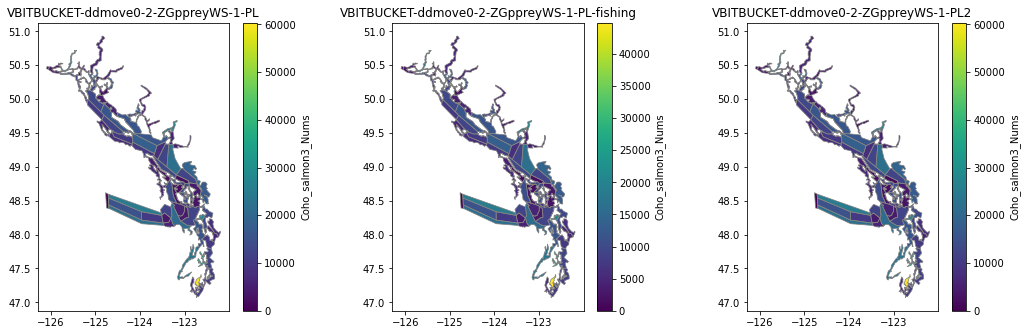

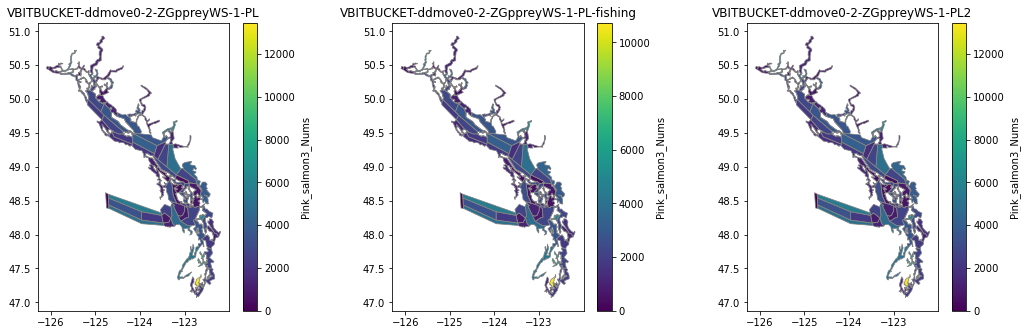

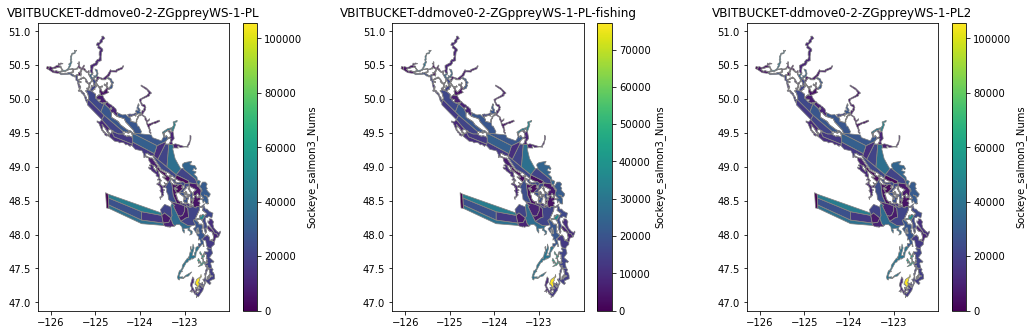

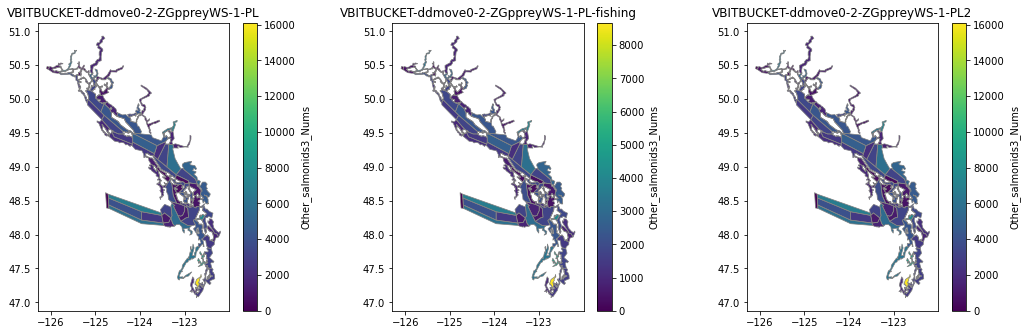

In [28]:
group = groups.wild_salmon
for species in group:
    spp_name = str(group[species]) + '3_Nums'
    map_water_column_linear(spp_name)

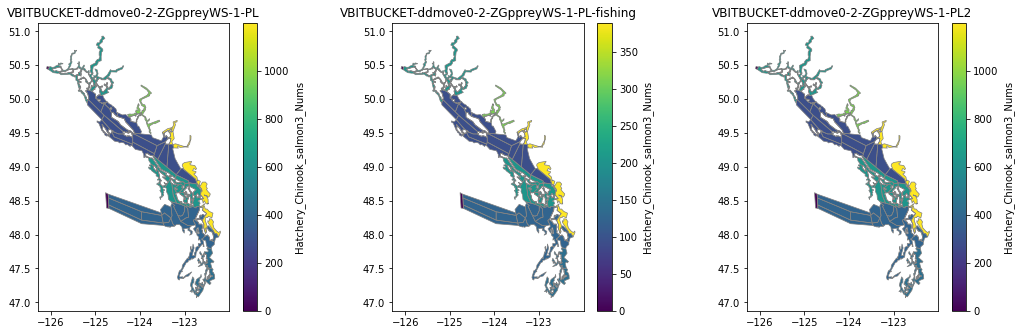

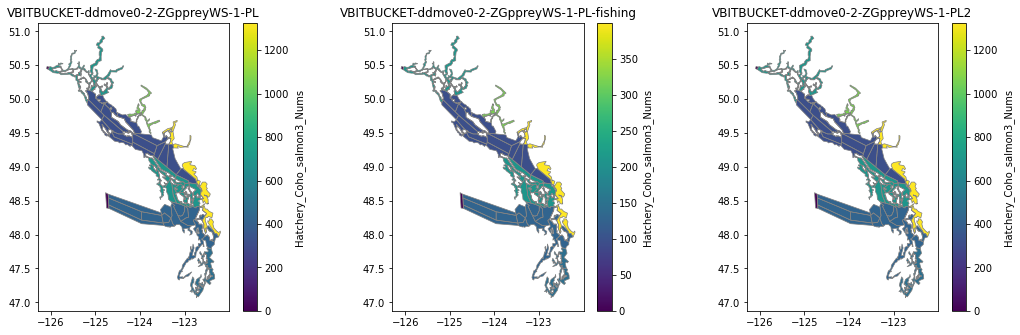

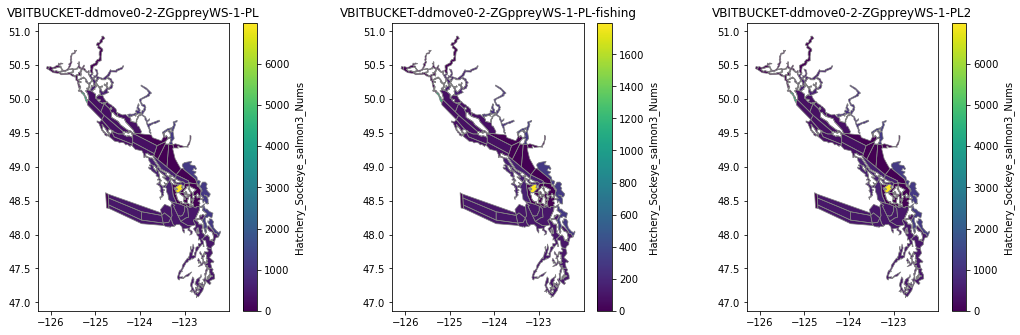

In [29]:
group = groups.hatchery_salmon
for species in group:
    spp_name = str(group[species]) + '3_Nums'
    map_water_column_linear(spp_name)

## Other fish

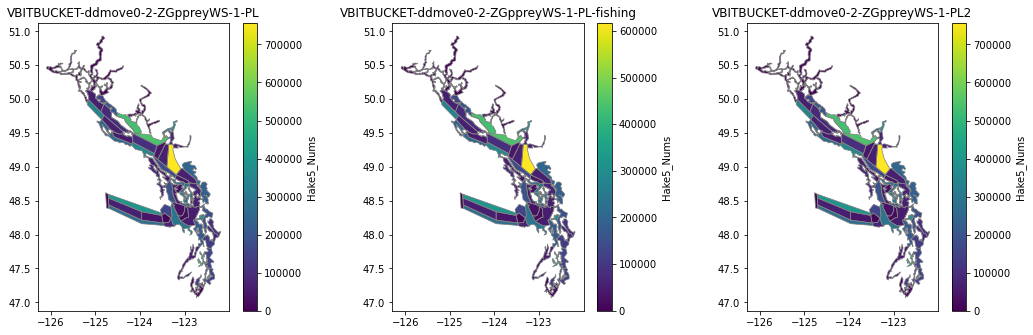

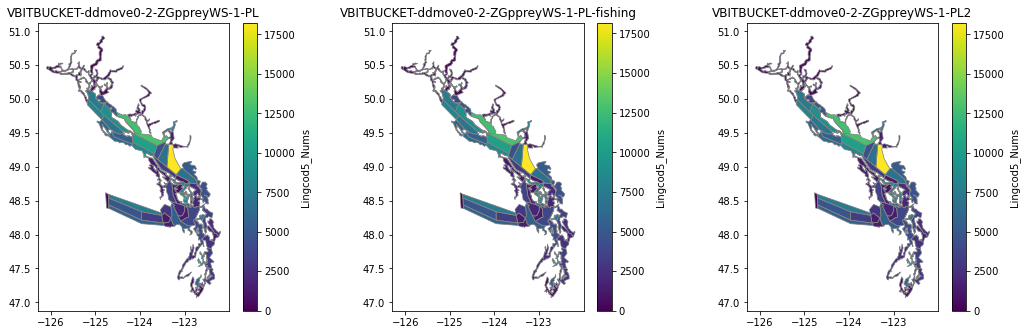

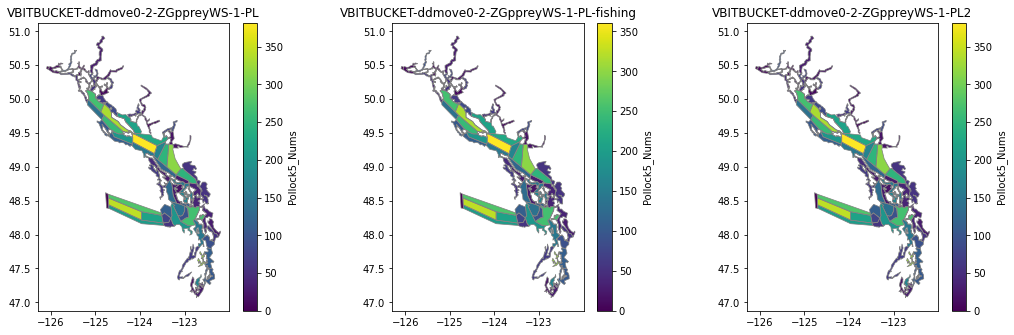

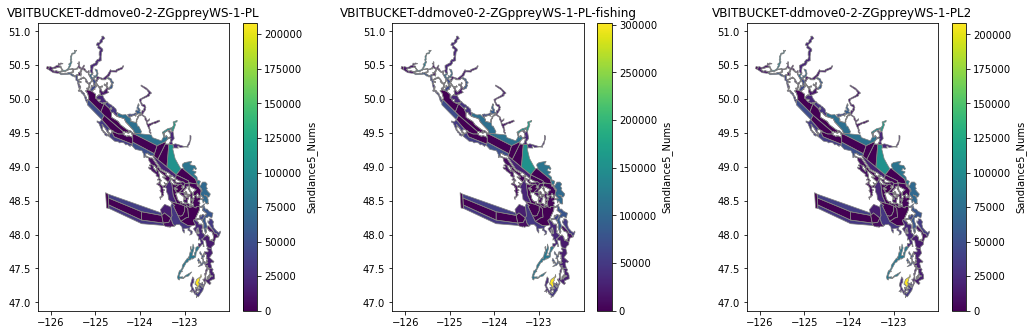

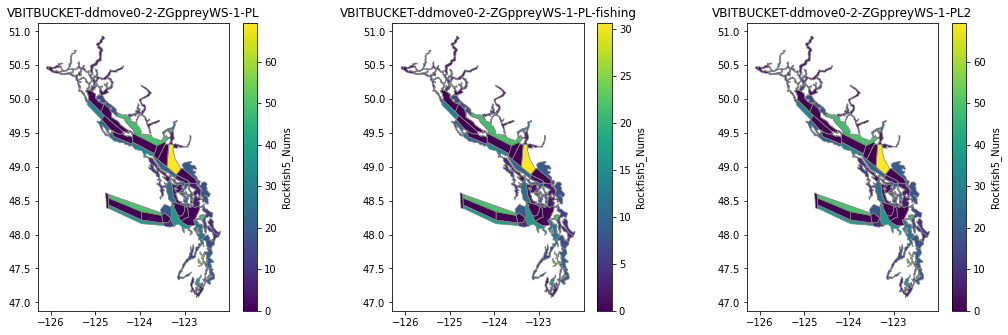

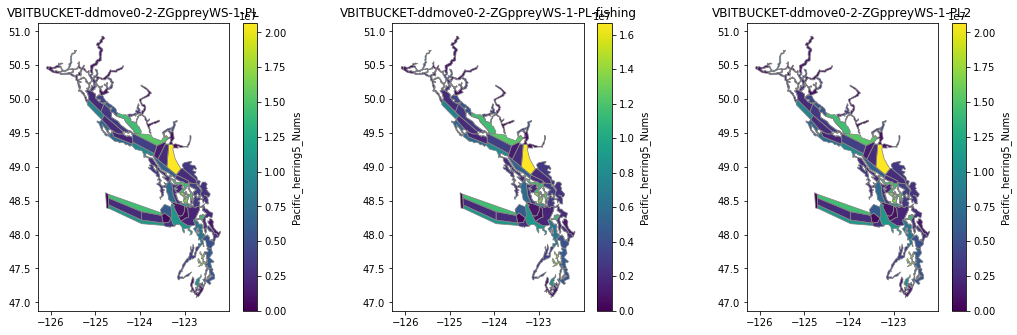

In [30]:
group = groups.named_fish
for species in group:
    spp_name = str(group[species]) + '5_Nums'
    map_water_column_linear(spp_name)

## Sharks

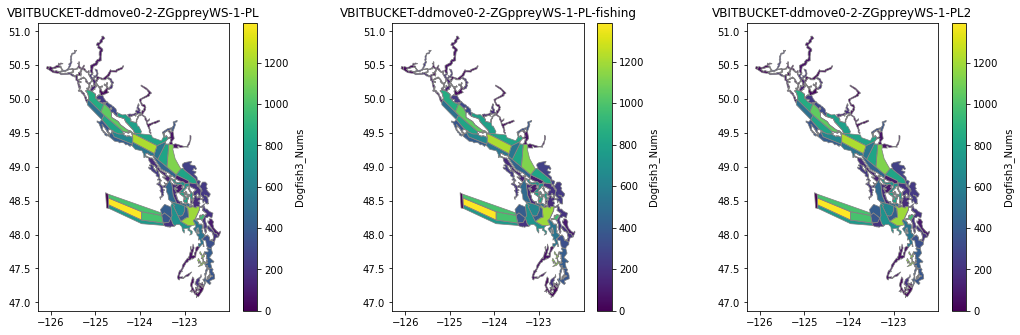

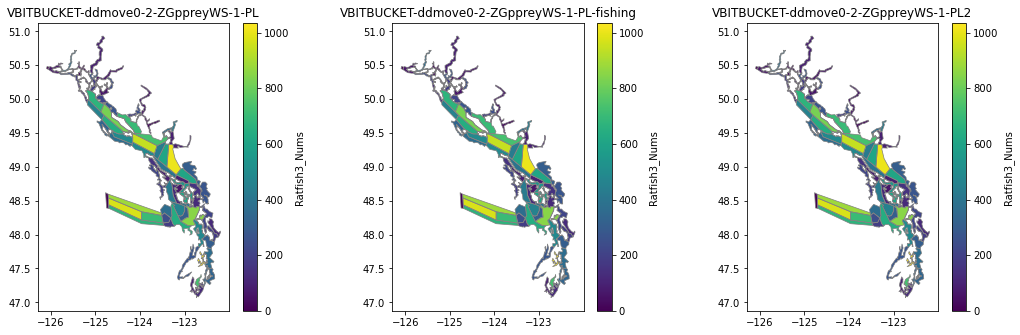

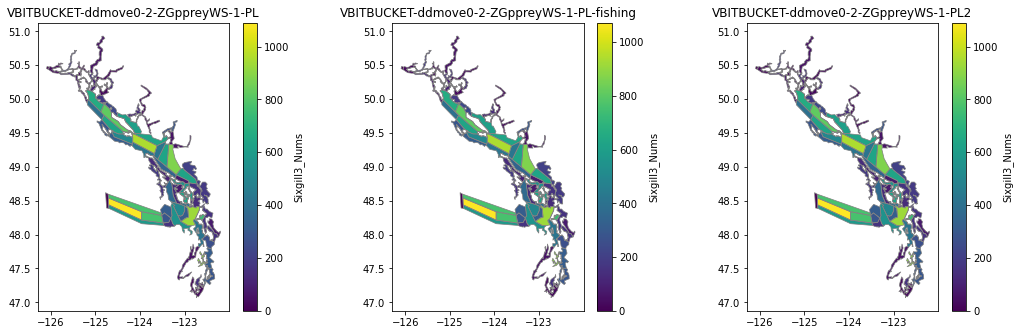

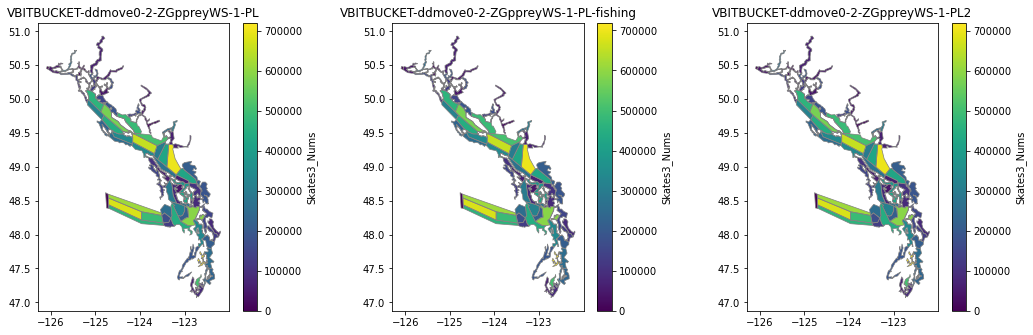

In [31]:
group = groups.sharks
for species in group:
    spp_name = str(group[species]) + '3_Nums'
    map_water_column_linear(spp_name)

## Mammals

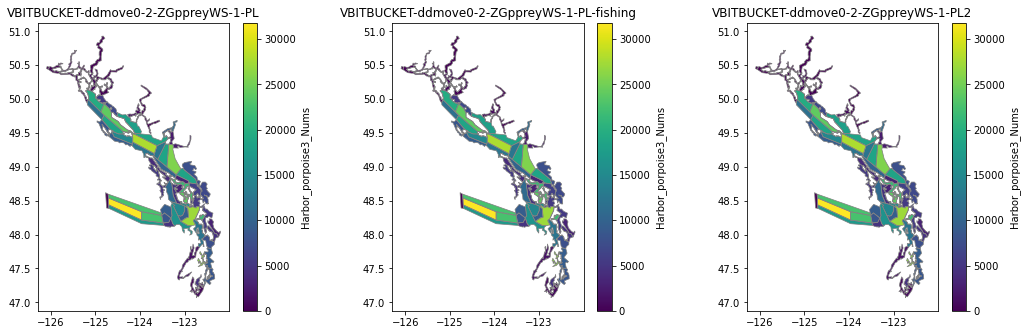

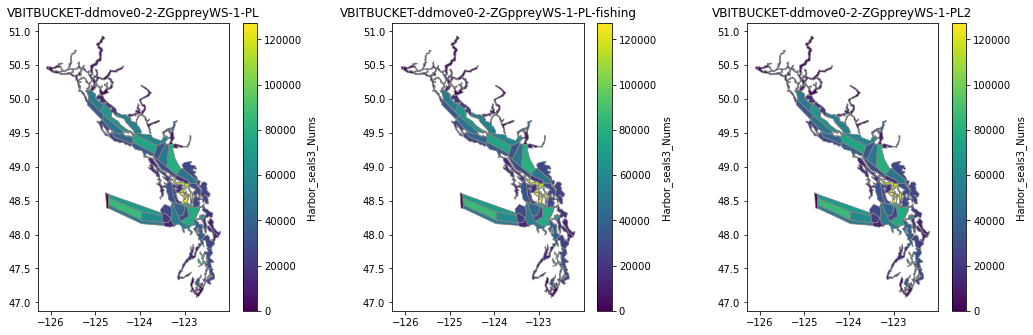

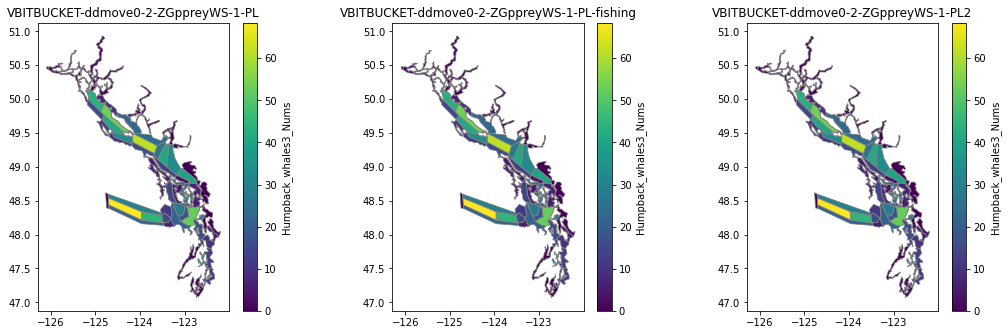

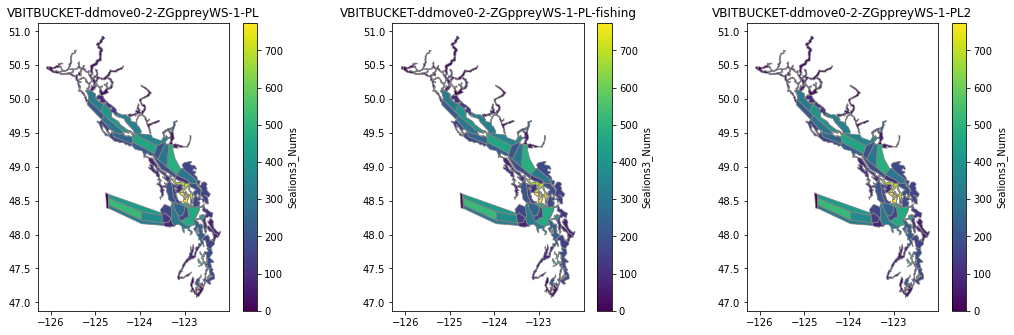

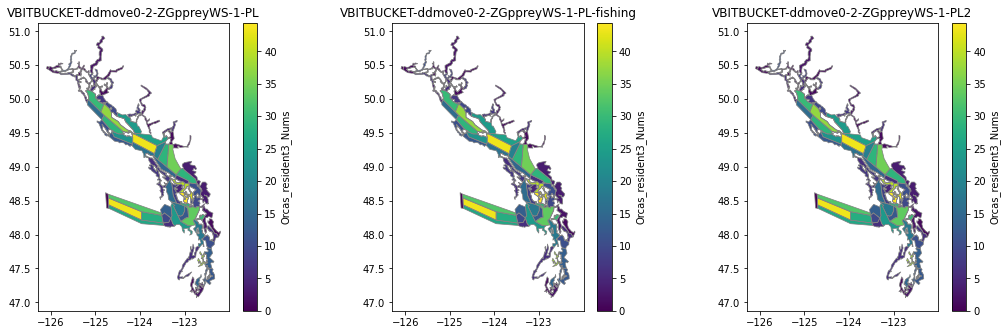

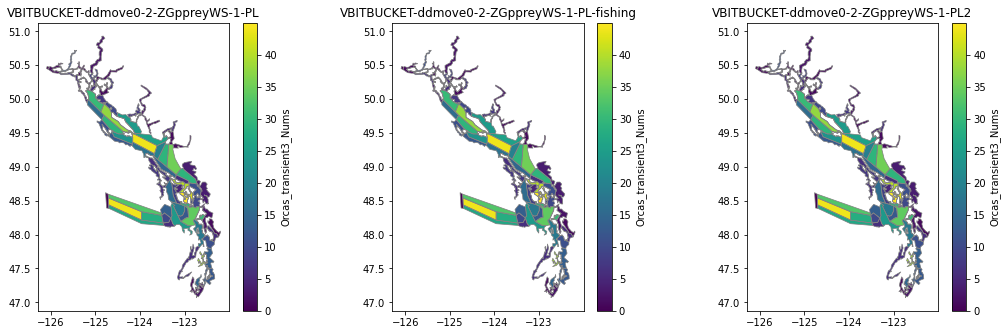

In [32]:
group = groups.mammals
for species in group:
    spp_name = str(group[species]) + '3_Nums'
    map_water_column_linear(spp_name)